### RXES Example Uses


[Download](https://www.dropbox.com/scl/fi/hsxt3cceaccyeijvqrg2l/Mn_foil_10micron_RIXSmapV6_0001.nxs?rlkey=pix5q9a7xaailxdoslqdh8ne8&dl=0) some test data to the directory of this notebook to be able to run the examples

In [3]:
!curl -L -o Mn_foil_10micron_RIXSmapV6_0001.nxs 'https://www.dropbox.com/scl/fi/hsxt3cceaccyeijvqrg2l/Mn_foil_10micron_RIXSmapV6_0001.nxs?rlkey=pix5q9a7xaailxdoslqdh8ne8&dl=1'


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    17    0    17    0     0     33      0 --:--:-- --:--:-- --:--:--    33
100   475    0   475    0     0    415      0 --:--:--  0:00:01 --:--:--   415
100  112M  100  112M    0     0  11.7M      0  0:00:09  0:00:09 --:--:-- 14.8M0  0:00:06  0:00:04 14.2M


You also need the following packages:

In [ ]:
!pip install numpy matplotlib h5py scipy

Import modules ec

In [97]:
%reset -f 
%load_ext autoreload
%autoreload 2

%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
from rxes import RXES

def make_colors(c, colmap='viridis'):
    import matplotlib.pyplot as plt
    cmap = plt.get_cmap(colmap)
    colors = [cmap(1.*i/c) for i in range(c)]
    return colors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load a mask, load the scan nxs file, use the calibrants in `'./calibrants'`, read data

In [139]:
mask = np.load('masks/merlin4x1_mask.npy')

rxes = RXES(['Mn_foil_10micron_RIXSmapV6_0001.nxs'],   # list of scan files
            k=['alpha'],  # which calibrants to use for each of the scans
            mask=mask, mask_style='avgs',  #load the mask, and how to handle it
            i0loc='APD2' # the location of the I0 channel
            )

rxes.load_calibrant()
rxes.read_data()


Notice how the first two entires are in lists, that's because you can load in multiple files at once.

The Merlin4x1 detector images are in `rxes.images`:

In [140]:
rxes.images.shape

(1, 109, 256, 1024)

Corresponding to 1 scan, 109 points, and the 256x1014 detector size.

Let's plot an image

In [141]:
rxes.plot_image(im_num=20,   # point in scan
                clim=[1, 200], 
                file_num=0)  # scan number. We only have 1

<AxesSubplot:>

This shows the (masked) detector image.

You can manually set a ROI (only vertically is necessary):
```
rxes.roi = [max, min]
```

Or try the auto_roi. Check how it works first:

In [142]:
?rxes.auto_roi

Signature:
rxes.auto_roi(
    im_num,
    guess=None,
    roi_width=2,
    file_num=0,
    clim=[1, 100],
    plot=True,
)
Docstring:
Autodetect Horizontal ROI, by fitting a 2D Gauss, then set roi to 2 x std (default)
im_num : int
    image number (scan point)
guess : [x, y] list of int
    Initial guess of the center for the 2D Gaussian fit. If nothing is 
    specified, it will use the center of the detector. This can fail
roi_width : float
    Set the ROI to center - x_std * std, center + x_std * std
file_num : int
    number of scan in your list of loaded scans
clim : [min, max]
    color scale limits if plotting
plot : bool
    Whether or not to plot the resulting ROI
File:      ~/Dropbox/DTU2/BEAMTIMES/2024_Soleil/analysis_code/XES_Test/analysis/rxes.py
Type:      method


Found the ROI:  [205, 175]


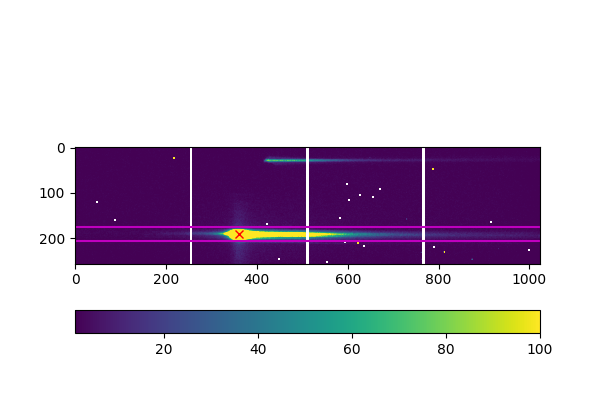

In [143]:
# This image has two peaks, and the main one isn't centered, so we have to help the auto ROI along a bit
# with an initial guess:
rxes.auto_roi(im_num=20, plot=True, guess=[365, 193], roi_width=4)
print('Found the ROI: ', rxes.roi)

Let's calculate and plot the RXES map. 

These two actions have been split up since if you're batch-processing many scans later on, you might not want to see each individual map.. 

In [144]:
# Calc and Plot the RXES map
rxes.calc_rxes()
rxes.plot_rxes()
plt.gca().set_ylim([5867, 5885])


(5867.0, 5885.0)

To practice a bit working with the `rxes` object, let us sum along the emitted energy to get a XAS plot from this.

In [145]:
xas_from_rxes = np.mean(rxes.rxes, axis=1)
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
ax.plot(rxes.e_inci[0], xas_from_rxes)
ax.set_xlabel('Incident Energy (eV)')
ax.set_ylabel('XAS')

Text(0, 0.5, 'XAS')

`rxes.e_inci[0]` is the incident energy of the first (and in this case only) scan loaded. 

Currently the object can only hold a single rxes map. That's a WIP... 

Let's get the XAS from the SDD instead. First, let's plot the SDD at the last image in the scan to get region to sum for XAS


In [148]:
ax = rxes.plot_sdd(-1)

Calculate and plot XAS. Here, it's normalized with I0, which at the time of this test scan had some issues:

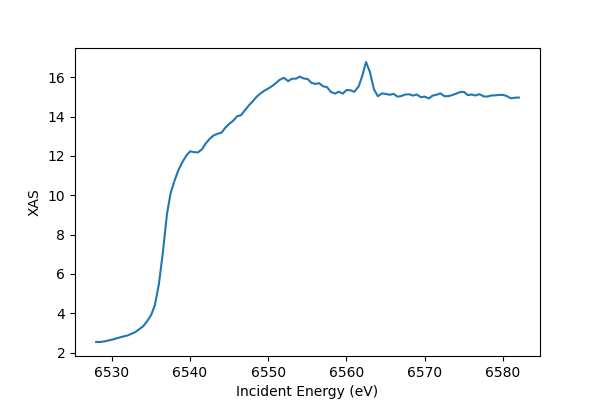

In [147]:
rxes.calc_xas([5500, 8000])
ax = rxes.plot_xas()
